In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical, Beta
from torch.autograd import Function
from utils import reparameterize
from tqdm import tqdm
from collections import deque

device = "cuda:0"

In [2]:
class Encoder(nn.Module):
    def __init__(self, latent_size = 32, input_channel = 3):
        super(Encoder, self).__init__()
        self.latent_size = latent_size
        self.main = nn.Sequential(
            nn.Conv2d(input_channel, 32, 4, stride=2), nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2), nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2), nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2), nn.ReLU()
        )
        self.linear_mu = nn.Linear(2*2*256, latent_size)

    def forward(self, x):
        x = self.main(x/255.0)
        x = x.view(x.size(0), -1)
        mu = self.linear_mu(x)
        return mu

In [3]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, has_continuous_action_space, action_std_init, latent_size):
        super(ActorCritic, self).__init__()

        self.main = Encoder(latent_size=latent_size)

        # saved checkpoints could contain extra weights such as linear_logsigma 
        weights = torch.load("checkpoints/encoder.pt", map_location=torch.device('cpu'))
        for k in list(weights.keys()):
            if k not in self.main.state_dict().keys():
                del weights[k]
        self.main.load_state_dict(weights)
        print("Loaded Weights")
        
        self.has_continuous_action_space = has_continuous_action_space

        # actor
        self.actor = nn.Sequential(
                        nn.Linear(latent_size*4, 400),
                        nn.ReLU(),
                        nn.Linear(400, 300),
                        nn.ReLU(),
                        nn.Linear(300, action_dim),
                        nn.Softmax(-1)
                    )
        # critic
        self.critic = nn.Sequential(
                            nn.Linear(latent_size*4, 400),
                            nn.ReLU(),
                            nn.Linear(400, 300),
                            nn.ReLU(),
                            nn.Linear(300, 1)
                        )
        
    def set_action_std(self, new_action_std):
        if self.has_continuous_action_space:
            self.action_var = torch.full((self.action_dim,), new_action_std * new_action_std).to(device)
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling ActorCritic::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")

    def forward(self):
        raise NotImplementedError
    
    def act(self, features):
        action_probs = self.actor(features)[0]
        dist = Categorical(action_probs)

        action = dist.sample()
        action_logprob = dist.log_prob(action)
        state_val = self.critic(features)

        return action.detach(), action_logprob.detach(), state_val.detach()
    
    def evaluate(self, state, action):
        features = self.main(state.float())
        action_probs = self.actor(features)
        dist = Categorical(action_probs)
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_values = self.critic(features)
        
        return action_logprobs, state_values, dist_entropy

In [4]:
model = ActorCritic(state_dim=3, action_dim=7, has_continuous_action_space=False, action_std_init=0.6, latent_size=16).to(device)

Loaded Weights


In [5]:
import torch
import torch.nn as nn
from torch.distributions import Categorical
import numpy as np
import gymnasium as gym
import minigrid
from minigrid.wrappers import ImgObsWrapper, RGBImgPartialObsWrapper, RGBImgObsWrapper
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from IPython import display
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

pygame 2.5.2 (SDL 2.28.2, Python 3.11.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [6]:
def preprocess(x):
    x = torch.from_numpy(x).float()
    if len(x.shape) == 3:
        x = x.permute(2, 0, 1).unsqueeze(0).to(device)
    else:
        x = x.permute(0, 3, 1, 2).to(device)
    return x

In [25]:
env = gym.make('MiniGrid-Empty-8x8-v0', render_mode="rgb_array")
env = RGBImgObsWrapper(env)
obs, info = env.reset() # This now produces an RGB tensor only

obs0 = obs["image"]
obs0 = preprocess(obs0)
feature0 = model.main(obs0.float())

state, reward, done, truncated, info = env.step(2)
obs1 = state["image"]
obs1 = preprocess(obs1)
feature1 = model.main(obs1.float())

state, reward, done, truncated, info = env.step(2)
obs2 = state["image"]
obs2 = preprocess(obs2)
feature2 = model.main(obs2.float())

state, reward, done, truncated, info = env.step(2)
obs3 = state["image"]
obs3 = preprocess(obs3)
feature3 = model.main(obs3.float())

stacked_features = torch.cat([obs0, obs1, obs2, obs3],3)
print(stacked_features.shape)

# plt.imshow(stacked_obs)

torch.Size([1, 3, 64, 256])


(64, 64, 3)


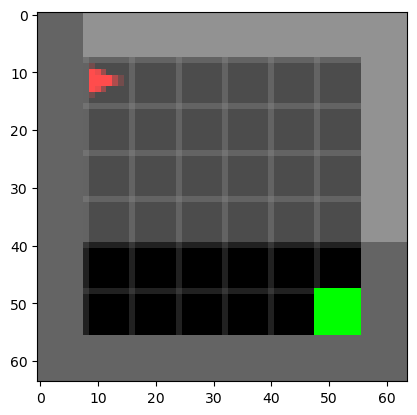

In [7]:
env = gym.make('MiniGrid-Empty-8x8-v0', render_mode="rgb_array")
env = RGBImgObsWrapper(env)
obs, info = env.reset() # This now produces an RGB tensor only
obs = obs["image"]
plt.imshow(obs)
print(obs.shape)

In [17]:
list(feature_queue)

[tensor([[-0.1628, -0.0033, -0.0008,  0.0116,  0.0354,  0.0064, -0.0013,  0.0071,
          -0.0068, -0.0093,  0.0067,  0.2602,  0.0124, -0.0070,  0.0347, -0.0207]],
        device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[-0.1628, -0.0033, -0.0008,  0.0116,  0.0354,  0.0064, -0.0013,  0.0071,
          -0.0068, -0.0093,  0.0067,  0.2602,  0.0124, -0.0070,  0.0347, -0.0207]],
        device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[-0.1628, -0.0033, -0.0008,  0.0116,  0.0354,  0.0064, -0.0013,  0.0071,
          -0.0068, -0.0093,  0.0067,  0.2602,  0.0124, -0.0070,  0.0347, -0.0207]],
        device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[ 0.6829, -0.0020,  0.0030,  0.0041, -0.0120,  0.0018,  0.0188, -0.0157,
           0.0036,  0.0115,  0.0094,  0.7957,  0.0072,  0.0111,  0.3675,  0.0197]],
        device='cuda:0', grad_fn=<AddmmBackward0>)]

In [23]:
data_array = []
timestamps = 100_000
obs, info = env.reset()

feature_queue = deque(maxlen=4)
blank1 = model.main(preprocess(np.zeros((64,64,3))))
blank2 = model.main(preprocess(np.zeros((64,64,3))))
blank3 = model.main(preprocess(np.zeros((64,64,3))))
feature_queue.append(blank1)
feature_queue.append(blank2)
feature_queue.append(blank3)

for t in range(timestamps):
    action = env.action_space.sample()
    obs, r, done, _, _ = env.step(action)
    obs = preprocess(obs['image'])
    
    # Add the current observation to the queue.
    feature = model.main(obs.float())
    feature_queue.append(feature)
    
    # Stack the images along a new axis to maintain individual image integrity.
    # This will result in an array shape of (4, height, width, channels) if your images are RGB.
    stacked_features = torch.cat(list(feature_queue), 1)
    [print(x) for x in list(feature_queue)]
    print("")
    
    if done:
        obs, info = env.reset()
        # Optionally, clear the image queue after reset if you want to start fresh for each episode.
        image_queue.clear()

tensor([[-0.1628, -0.0033, -0.0008,  0.0116,  0.0354,  0.0064, -0.0013,  0.0071,
         -0.0068, -0.0093,  0.0067,  0.2602,  0.0124, -0.0070,  0.0347, -0.0207]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.1628, -0.0033, -0.0008,  0.0116,  0.0354,  0.0064, -0.0013,  0.0071,
         -0.0068, -0.0093,  0.0067,  0.2602,  0.0124, -0.0070,  0.0347, -0.0207]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.1628, -0.0033, -0.0008,  0.0116,  0.0354,  0.0064, -0.0013,  0.0071,
         -0.0068, -0.0093,  0.0067,  0.2602,  0.0124, -0.0070,  0.0347, -0.0207]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 0.6829, -0.0020,  0.0030,  0.0041, -0.0120,  0.0018,  0.0188, -0.0157,
          0.0036,  0.0115,  0.0094,  0.7957,  0.0072,  0.0111,  0.3675,  0.0197]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

tensor([[-0.1628, -0.0033, -0.0008,  0.0116,  0.0354,  0.0064, -0.0013,  0.0071,
         -0.0068, -0.0093,  0.0067,  0.2602,  0.0124, -0.0070,

NameError: name 'image_queue' is not defined

In [47]:
model.act(stacked_features)

(tensor(5, device='cuda:0'),
 tensor(-1.9427, device='cuda:0'),
 tensor([[-0.0965]], device='cuda:0'))

In [55]:
env = gym.make('MiniGrid-LavaCrossingS9N1-v0', render_mode="rgb_array")
env = RGBImgObsWrapper(env)
obs, info = env.reset() # This now produces an RGB tensor only
obs = obs["image"]
obs = preprocess(obs)

In [57]:
model.act(obs)

(tensor(6, device='cuda:0'),
 tensor(-1.9096, device='cuda:0'),
 tensor([[0.0959]], device='cuda:0'))